In [2]:
import tensorflow as tf 
from tensorflow_probability.python import distributions as tfd  
from tensorflow_probability import layers as tfl 

2024-05-01 12:06:32.959840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 12:06:32.974146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 12:06:35.102416: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 12:06:38.829678: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 12:06:56.009194: W tensorflow/compiler/tf2

In [3]:
tf.config.experimental.set_memory_growth(tf.config.get_visible_devices("GPU")[0], True)

2024-05-01 12:07:41.721124: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 12:07:42.193455: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 12:07:42.193546: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [ ]:
class Custom(tf.keras.models.Model):
    def __init__(self, units, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.dense = tf.keras.layers.Dense(units*2, activation)
        self.dl = tfl.DistributionLambda(make_distribution_fn= lambda t: tfd.MultivariateNormalDiag(t[..., :self.units], tf.exp(t[..., self.units:])),
                                         convert_to_tensor_fn=lambda s: tf.squeeze(s.sample(1), 0))
    @tf.function 
    def call(self, inputs, *args):
        params = self.dense(inputs)
        return self.dl(params)

x = tf.cast(tf.random.normal(shape=(100, 1)), tf.float32)
custom = Custom(2)
output = custom(x)

custom.save("./model_normal_test")

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(custom)
converted = converter.convert()
with open("./tflitemodel2.tflite", "wb") as file:
    file.write(converted)

In [ ]:
def make_lambda(t):
    return tfd.OneHotCategorical(logits=tf.ones_like(t, dtype=tf.float32))

class Custom2(tf.keras.models.Model):
    def __init__(self, units, activation="relu", clusters=5, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.dl = tfl.DistributionLambda(make_distribution_fn= make_lambda, #lambda t: tfd.OneHotCategorical(logits=tf.ones_like(t, dtype=tf.float32)), 
                                         convert_to_tensor_fn=lambda s: tf.squeeze(s.sample(1), 0))
        self.dl2 = tfd.OneHotCategorical(logits=tf.ones(clusters, dtype=tf.float32))
        self.clusters = clusters 

    def build(self, input_shape):
        super().build(input_shape)

    @tf.function 
    def call(self, inputs, *args):
        B, d = tf.shape(inputs)[0], tf.shape(inputs)[1]
        x = tf.ones((B, d))
        print(B, d)
        print(x.shape)
        return self.dl(x), self.dl2.sample((B))

x = tf.cast(tf.random.normal(shape=(100, 5)), tf.float32)
custom = Custom2(2)
output = custom(x)

print("Saving...")
custom.compile("adam")
custom.save("./custom_model_test")

In [ ]:
from src import models, layers, utils
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np

reload(utils)
reload(models)
reload(layers)

length = 100
samples = 150
epochs = 1000

traj = utils.generate_trajectories(length=length, samples=samples) 
traj = tf.reshape(traj, (length, -1, 2))
traj = tf.transpose(traj, (1, 0, 2))

kl_zd_schedule = utils.KlScheduler("zd_loss_weight", 10)
kl_zg_schedule = utils.KlScheduler("zg_loss_weight", 10)
kl_p_schedule = utils.KlScheduler("entr_weight", 10)
vmrnn1 = models.VariationalMixtureRNN(output_units=2, hidden_units=10, clusters=2, use_sample_kl=True)
vmrnn1.compile("rmsprop")
_ = vmrnn1(traj)
'''hist = vmrnn1.fit(
    traj,
    epochs=epochs,
    batch_size=samples,
    callbacks=[kl_zd_schedule, kl_zg_schedule, kl_p_schedule],
)
vmrnn1.save("vmrnn1.keras")'''

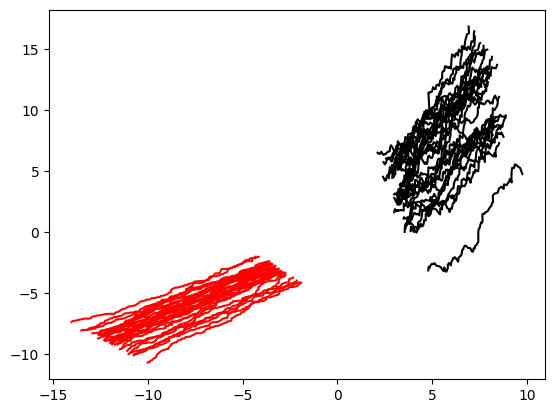

In [27]:
for i in range(30):
    plt.plot(traj[:, i, 0, 0], traj[:, i, 0, 1], color="black")
    plt.plot(traj[:, i, 1, 0], traj[:, i, 1, 1], color="red")

In [114]:
from src import data
from importlib import reload

reload(data)

path = "A:\\Users\\Claudio\\Documents\\Data\\motion-sense\\data"
subjects = data.process_motion_sense(path)

folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_1.csv  subject: 1
folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_10.csv  subject: 10
folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_11.csv  subject: 11
folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_12.csv  subject: 12
folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_13.csv  subject: 13
folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_14.csv  subject: 14
folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_15.csv  subject: 15
folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_16.csv  subject: 16
folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_17.csv  subject: 17
folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_18.csv  subject: 18
folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_19.csv  subject: 19
folder: A_DeviceMotion_

In [132]:
subjects.index = subjects.index.set_levels( [*subjects.index.levels[:-1], subjects.index.levels[-1].astype(int)])

In [137]:
subjects.to_csv("./df.csv")

In [144]:
subjects.index.get_level_values(-1).max()

16423

In [112]:
import sqlite3 as sql

db = sql.connect("./lite.db")
cursor = db.cursor()

cursor.execute("CREATE TABLE dataset(\
               subject CHAR(4),\
               movement CHAR(6), \
               attitude_roll FLOAT(10, 4), \
               attitude_pitch FLOAT(10, 4), \
               attitude_yaw FLOAT(10, 4), \
               gravity_x FLOAT(10, 4), \
               gravity_y FLOAT(10, 4), \
               gravity_z FLOAT(10, 4), \
               rotationRate_x FLOAT(10, 4), \
               rotationRate_y FLOAT(10, 4), \
               rotationRate_z FLOAT(10, 4), \
               userAcceleration_x FLOAT(10, 4), \
               userAcceleration_y FLOAT(10, 4), \
               userAcceleration_z FLOAT(10, 4))")


In [4]:
from src import models, layers, utils
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np

reload(utils)
reload(layers)
reload(models)

length = 100
samples = 150
sin = True 
if sin:
    out_dim = 1
    traj = utils.generate_sin((0.1, 0.9, 2.0), noise=0.1, length=length, samples=samples)
    traj = tf.cast(
    tf.expand_dims(tf.transpose(tf.reshape(traj, (length, -1)), (1, 0)), -1),
    tf.float32,
    )
else:
    out_dim = 2
    traj = utils.generate_trajectories(length=length, samples=samples) 
    traj = tf.reshape(traj, (length, -1, 2))
    traj = tf.transpose(traj, (1, 0, 2))

model = models.DiscreteVariationalMixtureRNN(out_dim, clusters=2)
optim = tf.keras.optimizers.RMSprop()

2024-05-01 12:07:55.859825: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 12:07:55.860009: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 12:07:55.860070: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 12:07:56.301239: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 12:07:56.301463: I external/local_xla/xla/stream_executor

In [41]:
@tf.function
def step(model, inputs):
    with tf.GradientTape() as tape:
        out = model(traj, training=True)
        loss = -tf.reduce_mean(out["elbo"])
    grad = tape.gradient(loss, model.trainable_variables)
    return grad, loss

In [42]:
epochs = 500
_ = model(traj)
prog = tf.keras.utils.Progbar(epochs)
for i in range(epochs):
    grad, loss = step(model, traj)    
    optim.apply_gradients(zip(grad, model.trainable_variables))
    prog.update(i, values=[("elbo",loss)], finalize=False)
prog.update(i+1, values=[("elbo",loss)], finalize=True)
model.save(f"./assets/saved_models/dvrnn_{'sin' if sin else 'diff'}.keras")

500/500 [==============================] - 568s 1s/step - elbo: 56.1959


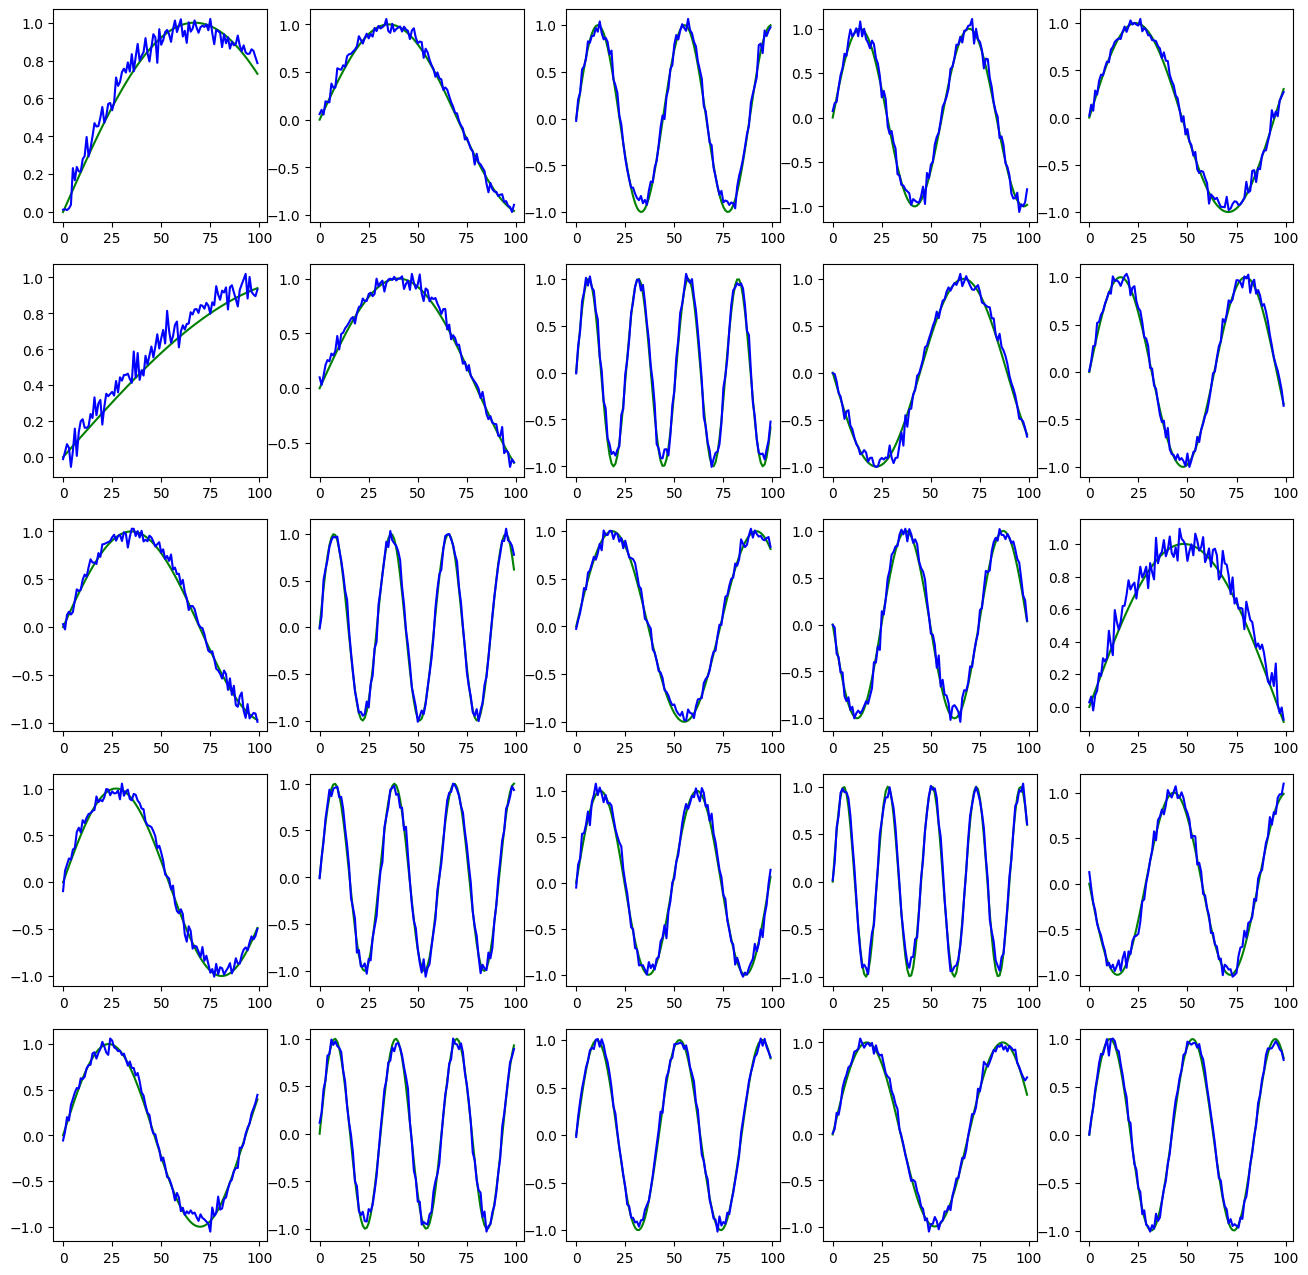

In [43]:
out = model(traj, training=False)
x_samples = out["x_samples"].numpy()
if sin:
    plt.figure(figsize=(16, 16))
    for i in range(1, 26):
        plt.subplot(5, 5, i)
        plt.plot(
            traj[i * 2, :, 0], color="green"
        )
        plt.plot(
            x_samples[i * 2, :, 0], color="blue"
        )
else:
    plt.figure(figsize=(16, 16))
    for i in range(1, 26):
        plt.subplot(5, 5, i)
        plt.plot(
            traj[i * 5, :, 0], traj[i * 5, :, 1], color="green"
        )
        plt.plot(
            x_samples[i * 5, :, 0], x_samples[i * 5, :, 1], color="blue"
        )

In [5]:
model = tf.keras.models.load_model("./assets/saved_models/dvrnn_sin.keras")

In [ ]:
reload(models)
model2 =  models.DiscreteVariationalMixtureRNN(out_dim, clusters=2)
_ = model2(traj)
model2.set_weights(model.get_weights())
model2.sample(None, 10, 10)

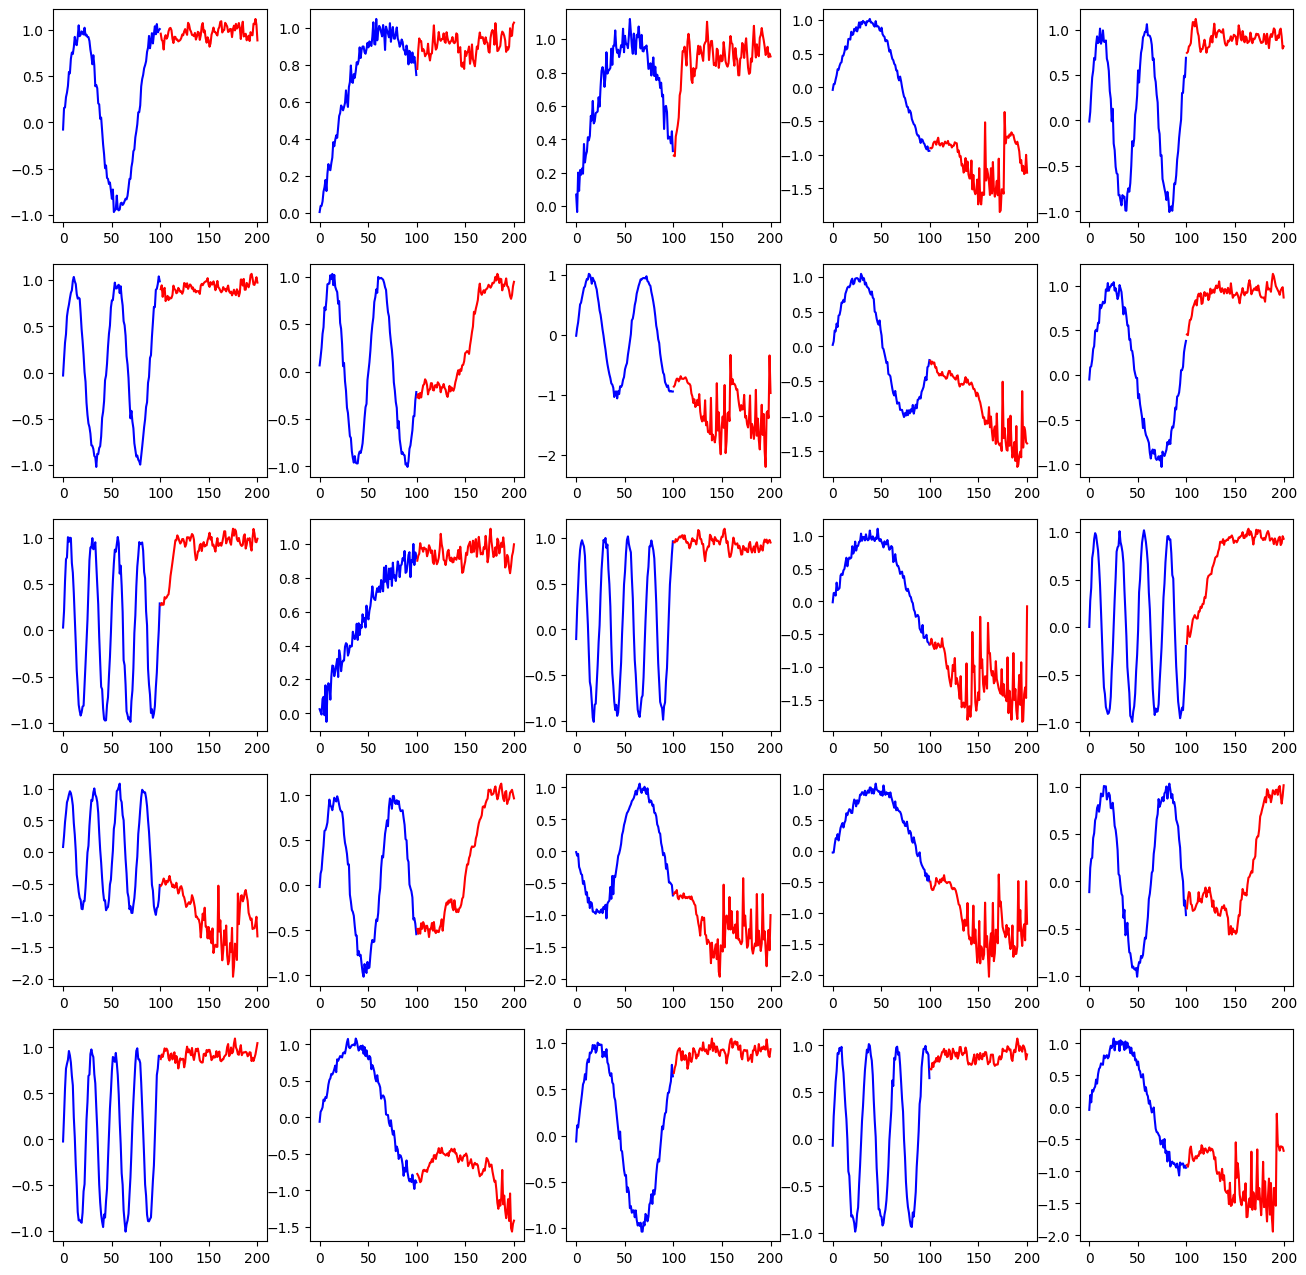

In [48]:
unconditional = False
length = 100
samples = 200

if unconditional:
    out = model.sample(None, samples, length)
    x_samples = out["x_samples"]
    plt.figure(figsize=(16, 16))
    for i in range(1, 26):
        plt.subplot(5, 5, i)
        plt.plot(
            x_samples[i, :, 0], color="blue"
        )
else:
    out = model.sample(traj, 30, length)
    x_samples = out["x_samples"]
    plt.figure(figsize=(16, 16))
    base = np.linspace(0, traj.shape[1] + length, traj.shape[1] + length)
    for i in range(1, 26):
        plt.subplot(5, 5, i)
        plt.plot(
            base[:-length],
            x_samples[i, :-length, 0], color="blue"
        )
        plt.plot(
            base[-length:],
            x_samples[i, -length:, 0], color="red"
        )

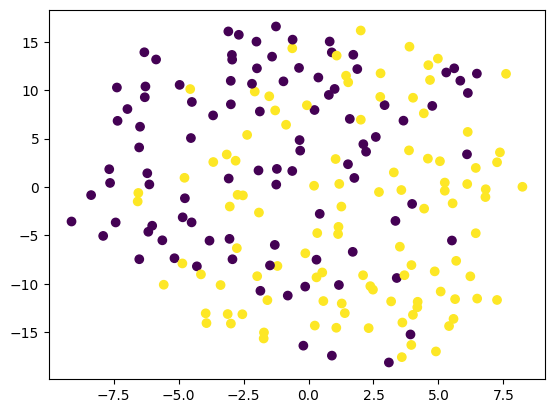

In [47]:
from sklearn.manifold import TSNE
zg = out["zg_posterior_sample"]
y = out["y_sample"]
emb = TSNE(n_components=2, perplexity=25)
emb = emb.fit_transform(zg.numpy())
plt.scatter(emb[:,0], emb[:, 1], c=y.numpy()[:,0])